# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [2]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [3]:
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

In [4]:
#from typing import Dict, Sequence
from datetime import datetime
#import torch
from collections import deque#, OrderedDict
from copy import deepcopy
import random
#import numpy as np
#import torch.nn.functional as F
#import torch.optim as optim
#import pandas as pd
#from matplotlib import pyplot as plt
#from PIL import Image
#import vizdoom as vzd
#from vizdoom import ScreenFormat

#import pandas as pd

#from gym import Env
from torch import nn
#from einops import rearrange

from doom_arena import VizdoomMPEnv#, ObsBuffer
#from doom_arena.render import render_episode
#from IPython.display import HTML
#from typing import Dict, Tuple

In [5]:
from agents.utils import *
from agents.utils_viz import *
from agents.helpers import *
from agents.dqn import EfficientDQN, epsilon_greedy, soft_update_target_network

In [6]:
rng = np.random.default_rng(100)

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [7]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["labels"], #["labels"],#, "automap"], #["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [8]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_PLAYERS = 1 #3
NUM_BOTS = 3 #1, #6
EPISODE_TIMEOUT = 200 #2000
# TODO: model hyperparams
GAMMA = 0.95
EPISODES = 2 # 500
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 20_000
LEARNING_RATE = 5e-5
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995 # 0.987
N_EPOCHS = 20
TARGET_UPDATE_FREQ = 1000
FRAME_SKIPPING = 0
FRAME_SKIPPING_STOP = 100
DEBUG = True
PRINT_EVERY = 20
VIDEO_DURING_TRAINING = False

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

DTYPE = torch.float32

obs_states = ExtraStates(PLAYER_CONFIG["extra_state"] + ["screen"], num_frames = N_STACK_FRAMES)

reward_fn = YourReward(num_players=NUM_PLAYERS)

def build_env():
    env = VizdoomMPEnv(
        num_players=NUM_PLAYERS, # 4 is max
        num_bots=NUM_BOTS,
        bot_skill=1, # Increased difficulty
        doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
        extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
        episode_timeout=EPISODE_TIMEOUT,
        n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
        crosshair=PLAYER_CONFIG["crosshair"],
        hud=PLAYER_CONFIG["hud"],
        screen_format=PLAYER_CONFIG["screen_format"],
        reward_fn=reward_fn,
        seed = rng.integers(1, 2000, NUM_PLAYERS),
        ticrate = 35*3,
    )
    return env

env = build_env()
with suppress_output(): # Reset to get player and game information
    env.reset()

Device: mps
Environment Seed: [1534]
Host 61662
Player 61662


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [10]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================
env_actions = EnvActions(env, rng=rng)

# main Q-network
model = EfficientDQN(
    obs_state_infos=obs_states,
    action_space=env_actions.action_space,
    feature_dim_cnns = 128,
    hidden_dim_heads = 1024,
).to(device, dtype=DTYPE)

# Load a model from file
# model = model.load_model("runs/20250620_151451/best_model_20250620_153705.pt")

Initialized model with 1377645 parameters!


In [11]:
target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-8)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Example of environment

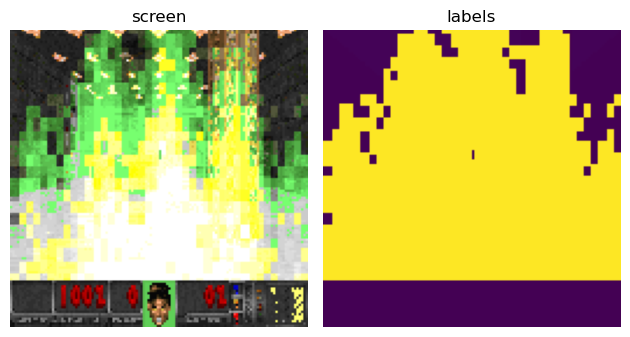

In [12]:
# Reset environment
with suppress_output():
    obs_test: list = env.reset()
    
for player in range(len(obs_test)):
    plot_images(obs_test[player], obs_states.get_dims())

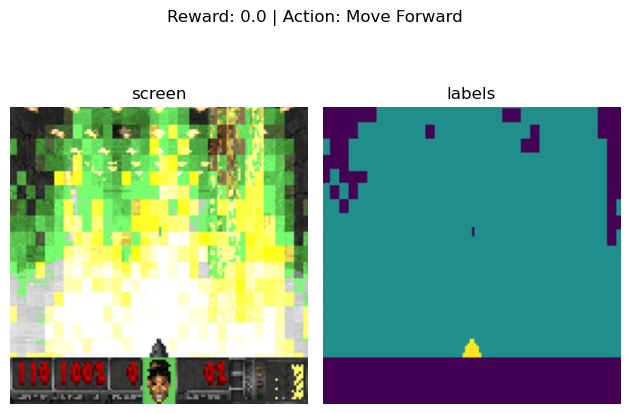

In [13]:
# Iterate 60 steps
STEPS = 10

for i in range(STEPS):
    #actions = env_actions.get_random_action(NUM_PLAYERS)
    actions = env_actions.get_action_value(1, NUM_PLAYERS)
    #actions = epsilon_greedy(env, model, obs_test, 1, env_actions, device, DTYPE)
    obs_test, reward = env.step(actions)[0:2]

for player in range(env.num_players):
    action_print = [actions] if isinstance(actions, int) else actions
    plot_images(obs_test[player], obs_states.get_dims(), **{"title": f"Reward: {reward[player]:.1f} | Action: {env_actions.get_action_name(action_print[player])}"})

### Example of Reward

In [14]:
player_idx = rng.integers(env.num_players)

player_game_vars = env.envs[player_idx].unwrapped._game_vars
player_game_vars_pre = env.envs[player_idx].unwrapped._game_vars_pre
reward = reward_fn(0, player_game_vars, player_game_vars_pre, 0)
print(f"Reward: {np.sum(reward)} | {reward}")
for key, value_now, value_old in zip(player_game_vars, player_game_vars.values(), player_game_vars_pre.values()):   
    print(f"{key+':':<25}{value_now:.0f} | {value_old:.0f}")

Reward: 0.02030889892578125 | (0.0, 0.0, -0.0, 0.02130889892578125, 0.0, -0.001, 0.0)
HEALTH:                  100 | 100
AMMO3:                   0 | 0
FRAGCOUNT:               0 | 0
ARMOR:                   0 | 0
HITCOUNT:                0 | 0
HITS_TAKEN:              0 | 0
DEAD:                    0 | 0
DEATHCOUNT:              0 | 0
DAMAGECOUNT:             0 | 0
DAMAGE_TAKEN:            0 | 0
KILLCOUNT:               0 | 0
SELECTED_WEAPON:         2 | 2
SELECTED_WEAPON_AMMO:    110 | 110
POSITION_X:              68 | 66
POSITION_Y:              224 | 224


## Training loop

In [15]:
# ---------------------  TRAINING LOOP  ----------------------

# Create folder for training
training_id = datetime.now().strftime("%Y%m%d_%H%M%S")
training_folder = os.path.join("runs", training_id)
os.makedirs(training_folder, exist_ok=True)

# Define logger
logger = FileLogger(training_folder, also_print=DEBUG)

In [16]:
# Training settings
q_loss_list, epsilon_history = [], []
reward_history = {player: [] for player in range(env.num_players)}
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0

#environments = {player_idx: build_env() for player_idx in range(NUM_PLAYERS)}

for episode in range(EPISODES):
    
    episode_action_counter = ActionCounter()
    
    with suppress_output():
        #obs = torch.stack([env.reset() for env in environments.values()])
        obs: torch.Tensor = env.reset()
    
    # Episode variables for each player
    episode_metrics = {player: {"frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "health_pickup": 0} for player in range(env.num_players)}
    episode_reward = {player: 0.0 for player in range(env.num_players)}
        
    done = False
    model.eval()
    
    episode_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Steps done: {steps_done} | Gathering rollout (currently {len(replay_buffer)})"
    logger.log(episode_msg)
    
    # ───────── rollout ─────────────────────────────────────────────
    while not done:
        
        # Skip Frames (Testing - I am aware that in the original paper they stacked the images. I want to get many more steps at the beginning)
        act = epsilon_greedy(env, model, obs, epsilon, env_actions, device, DTYPE, episode_action_counter)
        
        max_skip_steps = max(FRAME_SKIPPING * (episode < FRAME_SKIPPING_STOP), 1)
        for skip_steps in range(max_skip_steps):
            next_obs, reward, done, _ = env.step(act)            
            steps_done += 1

        # ----- reward definition ----------------
        for player_idx in range(env.num_players):
            episode_reward[player_idx] += np.sum(reward[player_idx]) # Should be a list with one value
            reward_components = reward_fn(None, env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars_pre, None)

            if len(reward_components) >= 6:
                episode_metrics[player_idx]["frags"] += reward_components[0]
                episode_metrics[player_idx]["hits"] += reward_components[1]
                episode_metrics[player_idx]["damage_taken"] += reward_components[2]
                episode_metrics[player_idx]["movement"] += reward_components[3]
                episode_metrics[player_idx]["ammo_efficiency"] += reward_components[4]
                episode_metrics[player_idx]["survival"] += reward_components[5]
                episode_metrics[player_idx]["health_pickup"] += reward_components[6]
        
            # ----- buffer and environment handling ----------------
            if env.num_players == 1:
                act = [act]
                
            replay_buffer.append((obs[player_idx], act[player_idx], reward[player_idx], next_obs[player_idx], done))
        
    obs = next_obs
    [reward_history[player_idx].append(reward) for player_idx, reward in episode_reward.items()] # Append rewards for every player
    epsilon_history.append(epsilon)

    # ───────── learning step (experience replay) ──────────────────
    if len(replay_buffer) >= BATCH_SIZE:

        model.train()
        train_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs"
        logger.log(train_msg)
        
        for epoch in range(N_EPOCHS):

            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors for training
            states = torch.stack(states).to(device, DTYPE)
            next_states = torch.stack(next_states).to(device, DTYPE)
            actions = torch.tensor(actions, device=device)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32) #.squeeze(1) # Added squeeze here
            dones = torch.tensor(dones, device=device, dtype=torch.float32)

            current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Target q values
            with torch.no_grad():
                next_q = target_model(next_states).max(1)[0] #.values
                target_q = rewards + GAMMA * next_q * (1 - dones)
            
            loss = loss_fn(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            q_loss_list.append(loss.item())
        
        # Update scheduler and epsilon
        scheduler.step()
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        # Update target network        
        target_update_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network..."
        logger.log(target_update_msg)
        soft_update_target_network(model, target_model, tau=1e-3)
        #hard_update_target_network(target_model, model)
        
    else:
        train_fail_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}"
        logger.log(train_fail_msg, print_once=True)

    # -------- logging ----------
    avg_reward = get_avg_reward(reward_history, episodes=PRINT_EVERY, round=0)
    avg_loss = np.mean(q_loss_list[-10:]) if q_loss_list else 0
    stacked_episode_reward = np.array([np.round(reward, 0) for reward in episode_reward.values()])
    
    action_counts = episode_action_counter.get_counts()

    # Rewards and losses
    reward_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Rewards:\n"
    reward_msg += f"\tReward: {stacked_episode_reward} | Avg Reward: {avg_reward} | Loss: {avg_loss:.4f} | ε: {epsilon:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}"
    reward_msg += f"\n\tMetrics - {[f'{metric}: {value}' for metric, value in get_average_result(episode_metrics).items()]}"
    reward_msg += f"\n\tActions - {', '.join([f"{k}: {v}" for k, v in sorted(action_counts.items())])}"
    
    logger.log(reward_msg, print_once = episode % PRINT_EVERY == 0)
        
    # Show the video 
    if VIDEO_DURING_TRAINING and episode % PRINT_EVERY * 2 == 0:
        replay_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replaying animation..."
        logger.log(replay_msg)
        with suppress_output():
            replay_episode(env, target_model, device, DTYPE, path=training_folder, store=True, random_player=False)
    
    # ───────── quick evaluation for best-model tracking ───────────
    quick_eval_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation..."
    logger.log(quick_eval_msg)

    with suppress_output():
        eval_obs = env.reset() # List of obs
        
    eval_episode_rewards = [0.0] * env.num_players
    eval_done = False
    model.eval()
 
    while not eval_done:
        eval_action_list = epsilon_greedy(env, model, eval_obs, 0, env_actions, device, dtype=DTYPE)
        eval_next_obs_list, eval_reward_list, eval_done, _ = env.step(eval_action_list)
        for i in range(env.num_players):
            eval_episode_rewards[i] += eval_reward_list[i]
        eval_obs = eval_next_obs_list
    
    mean_eval_reward = np.mean(eval_episode_rewards)
    
    if mean_eval_reward > best_reward:
        best_reward = mean_eval_reward
        model_name = "best_model_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".pt"
        model.save_model(path=training_folder, filename=model_name)
        best_model = deepcopy(model)

15:30:00 | Episode: 0 | Steps done: 0 | Gathering rollout (currently 0)
15:30:02 | Episode: 0 | Training for 20 epochs
15:30:08 | Episode: 0 | Updating target network...
15:30:08 | Episode: 0 | Rewards:
	Reward: [3.] | Avg Reward: 3.0 | Loss: 0.0408 | ε: 0.995 | LR: 4.97e-05
	Metrics - ['frags: 0', 'hits: 0', 'damage_taken: 0', 'movement: 0', 'ammo_efficiency: 2', 'survival: 0', 'health_pickup: 0']
	Actions - 0: 7, 1: 19, 2: 42, 3: 20, 4: 29, 5: 27, 6: 30, 7: 26
15:30:08 | Episode: 0 | Running quick evaluation...
Successfully stored the model: runs/20250621_153000/best_model_20250621_153011.pt
15:30:11 | Episode: 1 | Steps done: 200 | Gathering rollout (currently 200)
15:30:13 | Episode: 1 | Training for 20 epochs
15:30:14 | Episode: 1 | Updating target network...
15:30:14 | Episode: 1 | Rewards:
	Reward: [4.] | Avg Reward: 3.0 | Loss: 0.0322 | ε: 0.990 | LR: 4.88e-05
	Metrics - ['frags: 0', 'hits: 0', 'damage_taken: 0', 'movement: 0', 'ammo_efficiency: 2', 'survival: 0', 'health_picku

## Dump to ONNX

In [ ]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):
    model.eval()
        
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)
    
    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state, 
        f=filename,
        export_params=True,
        opset_version=17,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    
    # Add metadata
    onnx_model = onnx.load(filename)
    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)
    
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best


onnx_filename = os.path.join(training_folder, "enhanced_doom_agent.onnx")
onnx_dump(env, final_model, PLAYER_CONFIG, onnx_filename)
print(f"Best network exported to {onnx_filename}")

Best network exported to runs/20250621_153000/enhanced_doom_agent.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


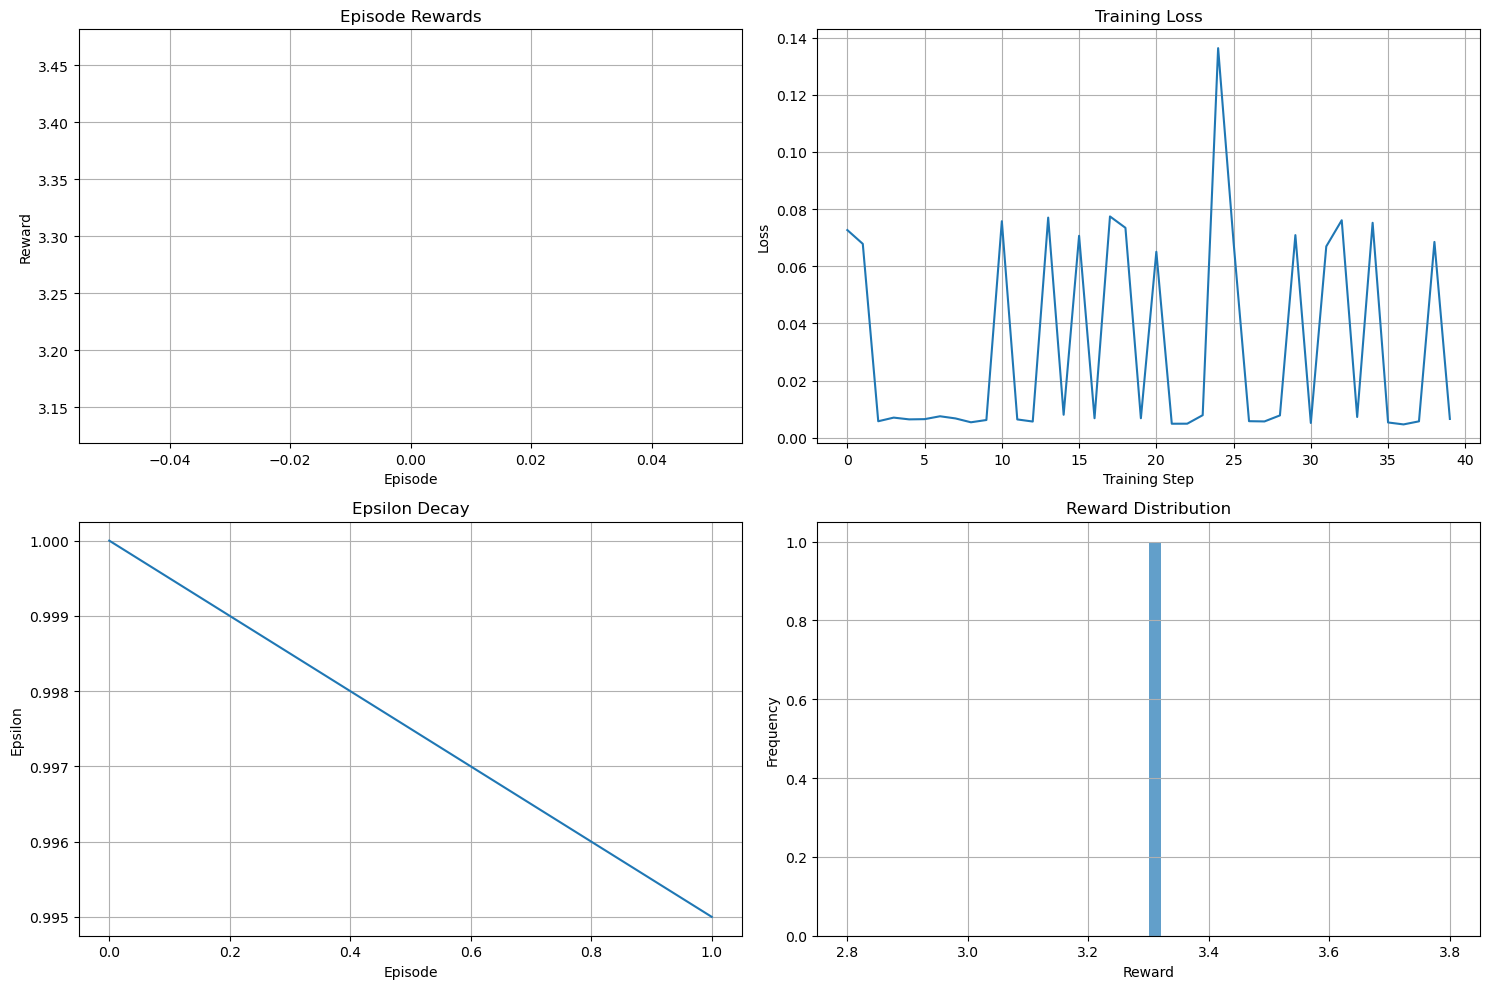

In [18]:
plot_training_metrics(get_avg_reward(reward_history, episodes=0), q_loss_list, epsilon_history)

Enabling replays!
Final evaluation - Total reward: 6.2
Disabling replays!
Animation saved to 2025-06-21_15-30-19_6.mp4


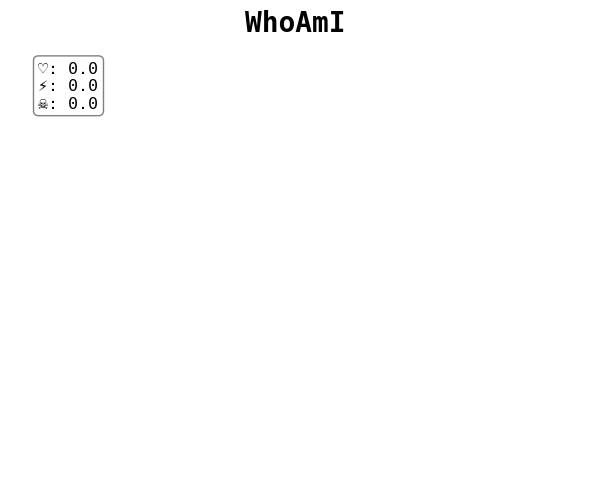

In [19]:
replay_episode(env, final_model.cpu(), device, DTYPE, store=True, random_player=False)